# **11 DSP Time Synchronization**

## **[1] Preliminaries**

1.1 Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.signal

1.2 Define functions (truncate functions) and classes

In [3]:
class fetchData:
    def __init__(self, FILENAME):
        self.testData = np.loadtxt(FILENAME)
        
    
    def return_tm_zacc_ts_te(self):
        self.tm = self.testData[:, 1]
        self.zacc = self.testData[:, 4]
        self.ts = [ self.tm[0] ]
        self.te = [ self.tm[-1] ]
        
        return self.tm, self.zacc, self.ts, self.te
    
    def return_izacc_interp(self, itm):
        self.izacc = np.interp( itm, self.tm, self.zacc )
        
        return self.izacc
        

def truncate( number, decimals=0 ) :
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance( decimals, int ) :
        raise TypeError( "decimal places must be an integer." )
    elif decimals < 0 :
        raise ValueError( "decimal places has to be 0 or more." )
    elif decimals == 0 :
        return math.trunc( number )
    factor = 10.0 ** decimals
    return math.trunc( number * factor ) / factor

1.3 Determine constants and permanent variables

In [4]:
DGREESAMP = 0.002

filename1 = "sync-dataset/xGold-20230819-17.49.txt"
filename2 = "sync-dataset/xSilver-20230819-17.50.txt"
filename3 = "sync-dataset/xBronze-20230819-17.49.txt"
filename4 = "sync-dataset/xCobalt-20230819-17.49.txt"
filename5 = "sync-dataset/vTitanium-20230819-17.49.txt"

1.4 Extract data from the files
* tm = time of the sensor
* zacc = acceleration at the z axis
* ts = list of time start `[  tm[0]  ]`
* te = list of time end `[  tm[-1]  ]`

In [5]:
testDat1 = fetchData(filename1)
testDat2 = fetchData(filename2)
testDat3 = fetchData(filename3)
testDat4 = fetchData(filename4)
testDat5 = fetchData(filename5)

tm1, zacc1, ts1, te1 = testDat1.return_tm_zacc_ts_te()
tm2, zacc2, ts2, te2 = testDat2.return_tm_zacc_ts_te()
tm3, zacc3, ts3, te3 = testDat3.return_tm_zacc_ts_te()
tm4, zacc4, ts4, te4 = testDat4.return_tm_zacc_ts_te()
tm5, zacc5, ts5, te5 = testDat5.return_tm_zacc_ts_te()

1.5 Find the startcut and endcut

The `np.concatenate` concatenates the list of values into 1 ndarray
`max` function finds the highest among the time start
`min` function finds the minimum of the time end

startcut -> endcut technically finds the latest start and earliest end among the sensors

In [6]:
startcut = max( np.concatenate(( ts1, ts2, ts3, ts4, ts5 )) )
endcut = min( np.concatenate(( te1, te2, te3, te4, te5 )) )

1.5.1 Explanation of the startcut and endcut

In [7]:
print("Converts all ts list to array",type(ts1))
print('ts: \n1 - {}\n2 - {}\n3 - {}\n4 - {}\n5 - {}\n'.format(ts1, ts2, ts3, ts4, ts5))


print('to: ',type(np.concatenate((ts1, ts2, ts3, ts4, ts5))))
print('{}'.format(np.concatenate((ts1, ts2, ts3, ts4, ts5))))


Converts all ts list to array <class 'list'>
ts: 
1 - [64251.9431]
2 - [64253.8874]
3 - [64252.9653]
4 - [64255.1357]
5 - [64256.0602]

to:  <class 'numpy.ndarray'>
[64251.9431 64253.8874 64252.9653 64255.1357 64256.0602]


1.6 truncates the startcut and endcut into three decimal places

`rst = truncate( startcut, 3 ) + dgresamp` - further adds 0.002 (sampling period)

In [8]:
rst = truncate( startcut, 3 ) + DGREESAMP
ret = truncate( endcut, 3 )

1.7 create the **timeVector** from rst -> ret with a constant interval of DGREESAMP

In [9]:
itm = np.arange( rst, ret, DGREESAMP )

1.8 Creates the interpolation for constant sampling period 

In [10]:
izacc1 = testDat1.return_izacc_interp(itm)
izacc2 = testDat2.return_izacc_interp(itm)
izacc3 = testDat3.return_izacc_interp(itm)
izacc4 = testDat4.return_izacc_interp(itm)
izacc5 = testDat5.return_izacc_interp(itm)

1.9 Plot the Data

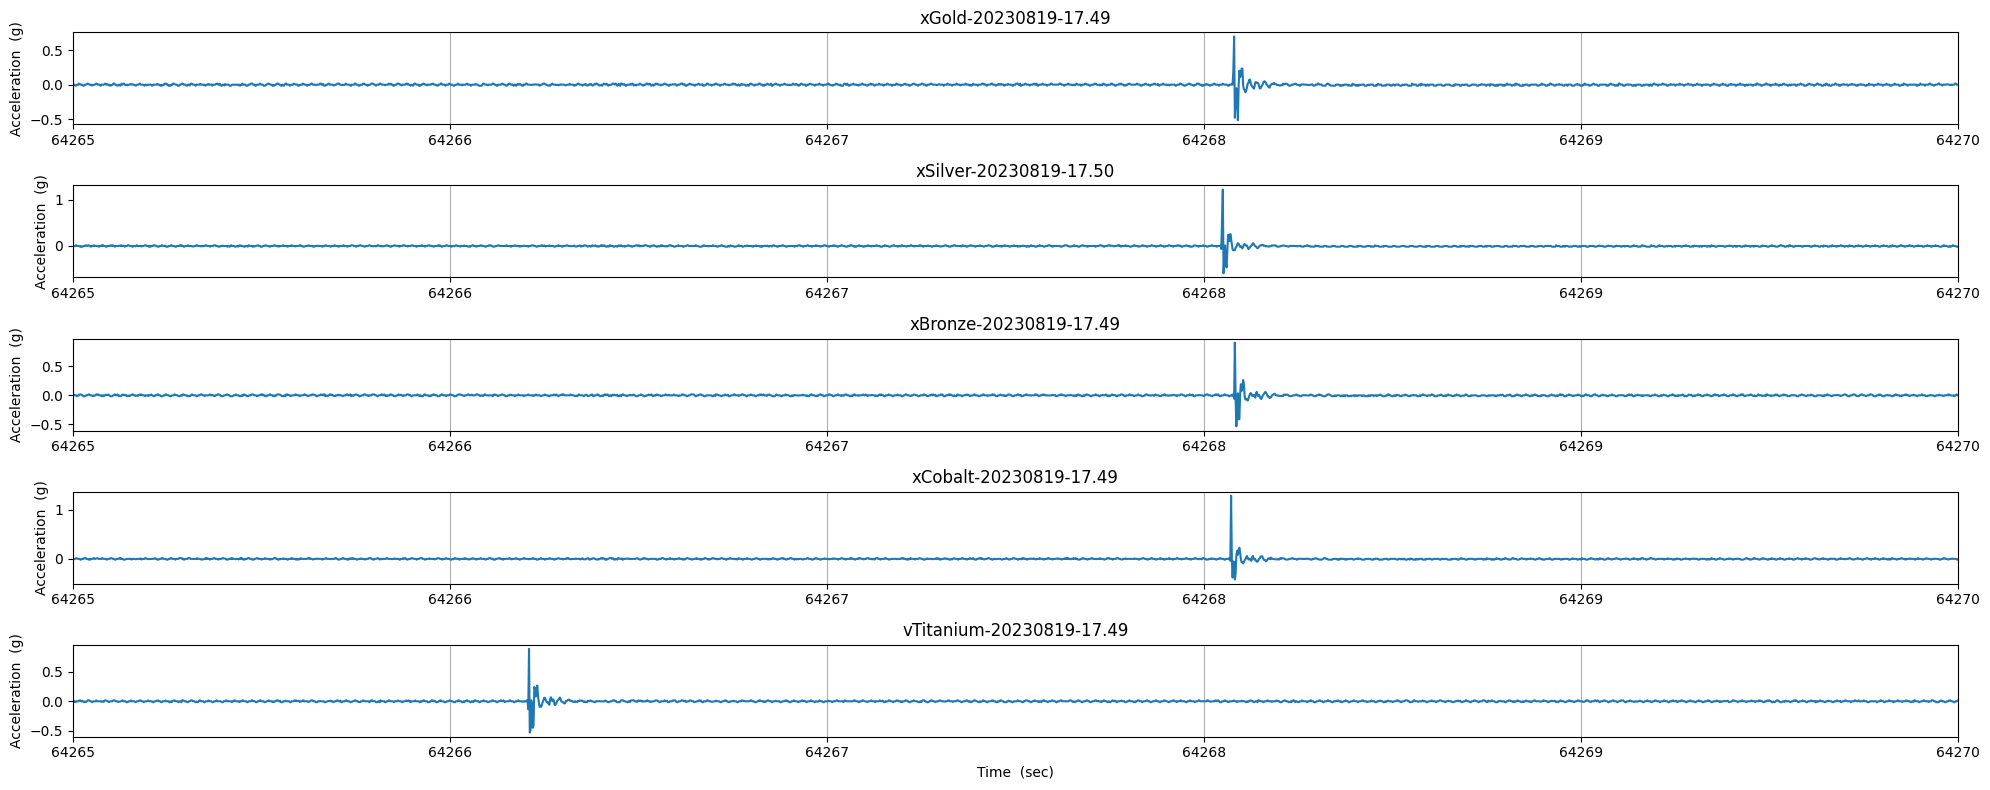

In [11]:
plt.figure(2).set_size_inches(20,8)
#xslim = rst
xslim = 64265
#xelim = ret
xelim = 64270

plt.subplot(5,1,1)
plt.plot( itm, izacc1 )
plt.xlim(xslim,xelim)
plt.ylabel('Acceleration  (g)')
plt.grid(axis='x')
plt.title("{}".format(filename1[13:-4]))

plt.subplot(5,1,2)
plt.plot( itm, izacc2 )
plt.xlim(xslim,xelim)
plt.ylabel('Acceleration  (g)')
plt.grid(axis='x')
plt.title("{}".format(filename2[13:-4]))

plt.subplot(5,1,3)
plt.plot( itm, izacc3 )
plt.xlim(xslim,xelim)
plt.ylabel('Acceleration  (g)')
plt.grid(axis='x')
plt.title("{}".format(filename3[13:-4]))

plt.subplot(5,1,4)
plt.plot( itm, izacc4 )
plt.xlim(xslim,xelim)
plt.ylabel('Acceleration  (g)')
plt.grid(axis='x')
plt.title("{}".format(filename4[13:-4]))

plt.subplot(5,1,5)
plt.plot( itm, izacc5 )
plt.xlim(xslim,xelim)
plt.xlabel('Time  (sec)')
plt.ylabel('Acceleration  (g)')
plt.grid(axis='x')
plt.title("{}".format(filename5[13:-4]))

plt.tight_layout()
plt.show()

## **[2] Time Synchronization**

`numpy.argmax (a, axis = None, out = None)`
* Where:
  * a = input array
  * axis = axis of the array
* Returns the indices of the maximum values along an axis
* [<u>np.argmax documentation</u>](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)

In [12]:
print('returns the index of the highest value')
print( izacc1.argmax(axis=0) )
print( izacc2.argmax(axis=0) )
print( izacc3.argmax(axis=0) )
print( izacc4.argmax(axis=0) )
print( izacc5.argmax(axis=0) )

returns the index of the highest value
6009
5994
6010
6005
5074


2.1 Using correlation function to find the time delay (`tmdelay`)  
* The `sigcorr` variable stores all of the values from `izacc5` from 0 up to the end less than 1500 indices. 
* Since the values of the `izacc5` are all interpolated with the time value basis of `itm`. It has a constant time interval. This is the same with all `izacc`
  * When correlated with different `izacc` (1,2,3..), the indices of the `izacc` are supposed to be the same since they have been interpolated with the same *time Vector* `itm`
  * Extracting the `argmax(axis=0)` it extracts the **index** in which the highest correlation is obtained. This **index** is expected to be the same but since there is a time difference from the measurement of different sensors, it is not the same in this case.
  * From the above assumptions, this means that there is a time shift of the same signal because of the hardware. The index signifies the amount of timeshift that happened. This can also be observed since the index `argmax(axis=0)` of the maximum value of the autocorrelation is 0 
  * Multiply the index with the DGREESAMP and get the time shift of the sensors

In [13]:
sigcorr = izacc5[0:(itm.size-1500)]

corr1 = np.correlate( a=izacc1, v=sigcorr )
tmdelay1 = corr1.argmax(axis=0) * DGREESAMP
print( "best-corr-1 time shift (sec) ", tmdelay1 )

corr2 = np.correlate( a=izacc2, v=sigcorr )
tmdelay2 = corr2.argmax(axis=0) * DGREESAMP
print( "best-corr-2 time shift (sec) ", tmdelay2 )

corr3 = np.correlate( a=izacc3, v=sigcorr )
tmdelay3 = corr3.argmax(axis=0) * DGREESAMP
print( "best-corr-3 time shift (sec) ", tmdelay3 )

corr4 = np.correlate( a=izacc4, v=sigcorr )
tmdelay4 = corr4.argmax(axis=0) * DGREESAMP
print( "best-corr-4 time shift (sec) ", tmdelay4 )

corr5 = np.correlate( a=izacc5, v=sigcorr )
tmdelay5 = corr5.argmax(axis=0) * DGREESAMP
print( "best-corr-5 time shift (sec) ", tmdelay5 )

best-corr-1 time shift (sec)  1.87
best-corr-2 time shift (sec)  1.84
best-corr-3 time shift (sec)  1.872
best-corr-4 time shift (sec)  1.862
best-corr-5 time shift (sec)  0.0


In [14]:
print("1. Finding the highest correlation based on sensor 5")
print("corr1 = np.correlate: \n{}".format(corr1))
print(f'\nFinding the index with the largest correlation value: \nIndex:{corr1.argmax(axis=0)}, value: {corr1[935]}')
print('\nFinding the time delay')
print(f'Time delay is: ',(corr1.argmax(axis=0) * DGREESAMP))

1. Finding the highest correlation based on sensor 5
corr1 = np.correlate: 
[ 0.02278154 -0.14408032 -0.26202788 ...  0.10464595 -0.09608156
 -0.24224194]

Finding the index with the largest correlation value: 
Index:935, value: 2.058624715682683

Finding the time delay
Time delay is:  1.87


Compare the values from above to the values of autocorrelation

In [15]:
print("Finding the auto correlation of sensor 5")
print("corr5 = np.correlate: \n{}".format(corr5))
print(f'\nFinding the index with the largest correlation value: \nIndex:{corr5.argmax(axis=0)}, value: {corr5[0]}')
print('\nFinding the time delay')
print(f'Time delay is: ',(corr5.argmax(axis=0) * DGREESAMP))

Finding the auto correlation of sensor 5
corr5 = np.correlate: 
[ 2.84041053  0.45175299 -0.23657028 ...  0.09744682  0.03033046
 -0.02290805]

Finding the index with the largest correlation value: 
Index:0, value: 2.8404105290818253

Finding the time delay
Time delay is:  0.0


The time delay for autocorrelation is 0 since it is comparing the signal to itself. 

The `argmax(axis = 0)` determines the index with the highest correlation value

2.2 Adjusts the entire time of the channels by the tmdelay
1. `tm1` is the *time extracted from the data* of the entire channel
2. `ctm` is the adjusted time

In [16]:
ctm1 = tm1 - tmdelay1
cts1 = [ ctm1[0] ]
cte1 = [ ctm1[-1] ]

ctm2 = tm2 - tmdelay2
cts2 = [ ctm2[0] ]
cte2 = [ ctm2[-1] ]

ctm3 = tm3 - tmdelay3
cts3 = [ ctm3[0] ]
cte3 = [ ctm3[-1] ]

ctm4 = tm4 - tmdelay4
cts4 = [ ctm4[0] ]
cte4 = [ ctm4[-1] ]

ctm5 = tm5 - tmdelay5
cts5 = [ ctm5[0] ]
cte5 = [ ctm5[-1] ]

2.3 Same with the process before, find the latest start and the earliest end

In [17]:
startcut = max( np.concatenate(( cts1, cts2, cts3, cts4, cts5 )) )
endcut = min( np.concatenate(( cte1, cte2, cte3, cte4, cte5 )) )

crst = truncate( startcut, 3 ) + DGREESAMP
cret = truncate( endcut, 3 )

citm = np.arange( crst, cret, DGREESAMP )

2.4 Interpolate the acceleration based on the:
1. `ctm1`   - adjusted time
2. `zacc1`  - original acceleration
3. `citm`   - new interpolated time interval

In [18]:
cizacc1 = np.interp( citm, ctm1, zacc1 )
cizacc2 = np.interp( citm, ctm2, zacc2 )
cizacc3 = np.interp( citm, ctm3, zacc3 )
cizacc4 = np.interp( citm, ctm4, zacc4 )
cizacc5 = np.interp( citm, ctm5, zacc5 )

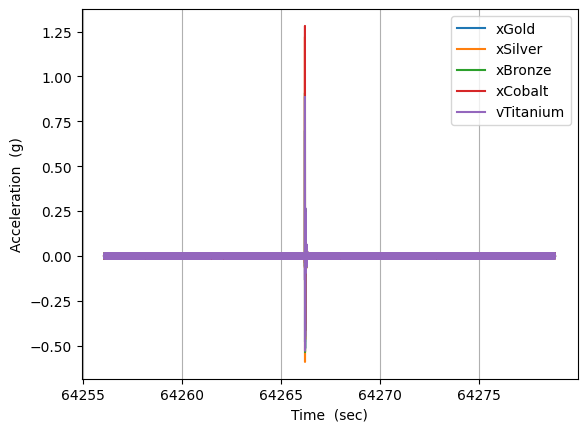

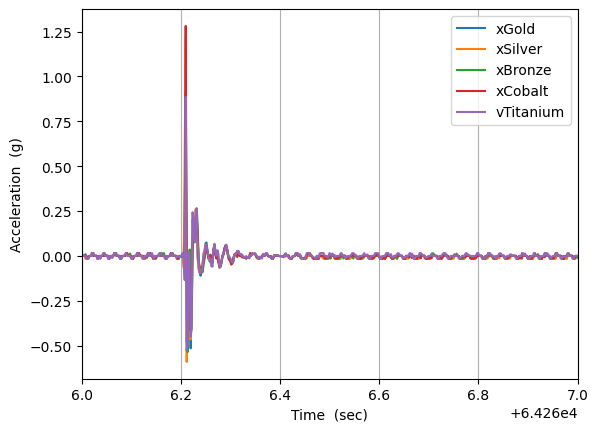

In [19]:
plt.figure(12)
plt.plot( citm, cizacc1, label='xGold' )
plt.plot( citm, cizacc2, label='xSilver' )
plt.plot( citm, cizacc3, label='xBronze' )
plt.plot( citm, cizacc4, label='xCobalt' )
plt.plot( citm, cizacc5, label='vTitanium' )
plt.xlabel('Time  (sec)')
plt.ylabel('Acceleration  (g)')
plt.legend()
plt.grid(axis='x')
plt.show()

plt.figure(14)
plt.plot( citm, cizacc1, label='xGold' )
plt.plot( citm, cizacc2, label='xSilver' )
plt.plot( citm, cizacc3, label='xBronze' )
plt.plot( citm, cizacc4, label='xCobalt' )
plt.plot( citm, cizacc5, label='vTitanium' )
plt.xlabel('Time  (sec)')
plt.ylabel('Acceleration  (g)')
plt.xlim([64266,64267])
plt.legend()
plt.grid(axis='x')
plt.show()


# **Other Details**

These other details are for double check specific values

In [25]:
n = citm.size
arr = np.array([0, n//4, n//2, n//5])

for values in arr:
    print('[1] Gold [{}]: {}'.format(values, cizacc1[values]))
    print('[2] Silver [{}]: {}'.format(values, cizacc2[values]))
    print('[3] Bronze [{}]: {}'.format(values, cizacc3[values]))
    print('[4] Cobalt [{}]: {}'.format(values, cizacc4[values]))
    print('[5] Titanium [{}]: {}'.format(values, cizacc5[values]))
    
    print('\n')
    




[1] Gold [0]: 0.00033066666666666666
[2] Silver [0]: 0.00829499993048732
[3] Bronze [0]: 0.00010492307695321402
[4] Cobalt [0]: 0.00017457142868131039
[5] Titanium [0]: 0.00048314285714285717


[1] Gold [2847]: 0.0003006664407751323
[2] Silver [2847]: 0.00024333351958491343
[3] Bronze [2847]: 0.01476609113980898
[4] Cobalt [2847]: 0.000205214308035513
[5] Titanium [2847]: 0.00033038922830692236


[1] Gold [5695]: -0.015398
[2] Silver [5695]: -0.015346667539703424
[3] Bronze [5695]: -0.0155699703004808
[4] Cobalt [5695]: -0.015372922602348097
[5] Titanium [5695]: -0.003315147583477585


[1] Gold [2278]: -0.00019925029018565268
[2] Silver [2278]: -3.759988418615724e-05
[3] Bronze [2278]: -0.01563438473830955
[4] Cobalt [2278]: -0.01446170381269133
[5] Titanium [2278]: -0.00012012526271436768


